In [ ]:
# ========================= DOWNLOAD AND ORGANIZE DATASET =========================

# Define paths
DATA_PATH = '/content/satellite_data'  # Path to save the dataset in Drive

# Download and extract the dataset
!curl -SL https://storage.googleapis.com/wandb_datasets/dw_train_86K_val_10K.zip > dw_data.zip
!unzip dw_data.zip
!rm dw_data.zip

# Move the extracted dataset to Google Drive
!mkdir -p {DATA_PATH}
!mv droughtwatch_data/train {DATA_PATH}/train
!mv droughtwatch_data/val {DATA_PATH}/val
!rm -r droughtwatch_data  # Clean up

# Verify dataset location and structure
import os
print(f"Train files: {len(os.listdir(DATA_PATH + '/train'))}")
print(f"Validation files: {len(os.listdir(DATA_PATH + '/val'))}")


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2050M  100 2050M    0     0  19.7M      0  0:01:43  0:01:43 --:--:-- 19.9M
Archive:  dw_data.zip
   creating: droughtwatch_data/
   creating: droughtwatch_data/val/
  inflating: droughtwatch_data/val/part-r-00090  
  inflating: droughtwatch_data/val/part-r-00061  
  inflating: droughtwatch_data/val/part-r-00052  
  inflating: droughtwatch_data/val/part-r-00043  
  inflating: droughtwatch_data/val/part-r-00040  
  inflating: droughtwatch_data/val/part-r-00042  
  inflating: droughtwatch_data/val/part-r-00067  
  inflating: droughtwatch_data/val/part-r-00026  
  inflating: droughtwatch_data/val/part-r-00046  
  inflating: droughtwatch_data/val/part-r-00023  
  inflating: droughtwatch_data/val/part-r-00083  
  inflating: droughtwatch_data/val/part-r-00011  
  inflating: droughtwatch_data/val/part-r-00058  
  inflating: droughtwat

In [ ]:
import os
import tensorflow as tf
import numpy as np

def combine_rgb(b2, b3, b4):
    blue = tf.io.decode_raw(b2, tf.uint8)
    green = tf.io.decode_raw(b3, tf.uint8)
    red = tf.io.decode_raw(b4, tf.uint8)

    img_size = int(tf.sqrt(tf.cast(tf.shape(blue)[0], tf.float32)))
    blue = tf.reshape(blue, (img_size, img_size))
    green = tf.reshape(green, (img_size, img_size))
    red = tf.reshape(red, (img_size, img_size))

    rgb_image = tf.stack([red, green, blue], axis=-1)
    return rgb_image

def parse_tfrecord(record):
    feature_description = {
        "B2": tf.io.FixedLenFeature([], tf.string),
        "B3": tf.io.FixedLenFeature([], tf.string),
        "B4": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    parsed = tf.io.parse_single_example(record, feature_description)
    rgb_image = combine_rgb(parsed["B2"], parsed["B3"], parsed["B4"])
    label = parsed["label"]
    return rgb_image, label

def create_balanced_datasets(raw_dataset):
    # Separate dataset by original classes
    class_0 = raw_dataset.filter(lambda x, y: y == 0)
    class_1 = raw_dataset.filter(lambda x, y: y == 1)
    class_2 = raw_dataset.filter(lambda x, y: y == 2)
    class_3 = raw_dataset.filter(lambda x, y: y == 3)

    # Training data preparation
    # New class 0 (10000 from each of original class 0 and 1)
    train_class_0_samples = class_0.shuffle(buffer_size=50000, seed=42).take(10000)
    train_class_1_samples = class_1.shuffle(buffer_size=50000, seed=42).take(10000)

    # New class 1 (all samples from original class 2 and 3)
    train_class_2_samples = class_2.shuffle(buffer_size=50000, seed=42)
    train_class_3_samples = class_3.shuffle(buffer_size=50000, seed=42)

    # Validation data preparation
    # New class 0 (2000 from each of original class 0 and 1)
    val_class_0_samples = class_0.shuffle(buffer_size=50000, seed=43).take(2000)
    val_class_1_samples = class_1.shuffle(buffer_size=50000, seed=43).take(2000)

    # New class 1 (2000 from each of original class 2 and 3)
    val_class_2_samples = class_2.shuffle(buffer_size=50000, seed=43).take(2000)
    val_class_3_samples = class_3.shuffle(buffer_size=50000, seed=43).take(2000)

    # Combine and assign new labels for training data
    new_class_0_train = train_class_0_samples.concatenate(train_class_1_samples).map(
        lambda x, y: (x, tf.constant(0, dtype=tf.int64))
    )
    new_class_1_train = train_class_2_samples.concatenate(train_class_3_samples).map(
        lambda x, y: (x, tf.constant(1, dtype=tf.int64))
    )

    # Combine and assign new labels for validation data
    new_class_0_val = val_class_0_samples.concatenate(val_class_1_samples).map(
        lambda x, y: (x, tf.constant(0, dtype=tf.int64))
    )
    new_class_1_val = val_class_2_samples.concatenate(val_class_3_samples).map(
        lambda x, y: (x, tf.constant(1, dtype=tf.int64))
    )

    # Create final datasets
    train_dataset = new_class_0_train.concatenate(new_class_1_train).shuffle(
        buffer_size=50000, seed=42
    )
    val_dataset = new_class_0_val.concatenate(new_class_1_val).shuffle(
        buffer_size=50000, seed=42
    )

    return train_dataset, val_dataset

# Function to count class distribution
def get_class_distribution(dataset):
    class_count = {0: 0, 1: 0}
    for _, label in dataset:
        class_count[int(label.numpy())] += 1
    return class_count

# Set up the paths
DATA_PATH = '/content/satellite_data'

# Create raw dataset
train_tfrecords = tf.data.Dataset.list_files(os.path.join(DATA_PATH, "train/part*"))
raw_train_dataset = tf.data.TFRecordDataset(train_tfrecords).map(
    parse_tfrecord, num_parallel_calls=tf.data.AUTOTUNE
)

# Create balanced training and validation datasets
train_dataset, val_dataset = create_balanced_datasets(raw_train_dataset)

# Verify the class distribution
train_dist = get_class_distribution(train_dataset)
val_dist = get_class_distribution(val_dataset)

print("Training dataset distribution:", train_dist)
print("Validation dataset distribution:", val_dist)

# Prepare final datasets for training
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

final_train_dataset = train_dataset.cache().shuffle(
    buffer_size=50000, seed=42
).batch(BATCH_SIZE).prefetch(AUTOTUNE)

final_val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

Training dataset distribution: {0: 20000, 1: 21652}
Validation dataset distribution: {0: 4000, 1: 4000}


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications
import matplotlib.pyplot as plt
import pickle

# Dataset preparation function
def prepare_datasets(train_dataset, val_dataset, batch_size=32):
    def preprocess(image, label):
        image = tf.cast(image, tf.float32) / 255.0
        label = tf.cast(label, tf.float32)
        return image, label

    train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.cache().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    val_dataset = val_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    val_dataset = val_dataset.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset

# Prepare the datasets
BATCH_SIZE = 32
final_train_dataset, final_val_dataset = prepare_datasets(train_dataset, val_dataset, BATCH_SIZE)

# MobileNetV2-based model creation function
def create_mobilenetv2_model(input_shape=(65, 65, 3), train_base_model=False):
    base_model = applications.MobileNetV2(
        weights='imagenet',  # Use pretrained weights
        include_top=False,   # Exclude fully connected layers
        input_shape=input_shape
    )

    # Set trainability of the base model
    base_model.trainable = train_base_model

    # Add custom layers
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=train_base_model)

    # Global Average Pooling and custom fully connected layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model

# Create and compile the MobileNetV2 model
model = create_mobilenetv2_model(train_base_model=True)  # Set to True to include all 155 layers
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ModelCheckpoint(
        'best_mobilenetv2_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

# Train the model
EPOCHS = 50
history = model.fit(
    final_train_dataset,
    validation_data=final_val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks,
    steps_per_epoch=1250,
    verbose=1
)

# Save training history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

# Display the complete model summary with all layers
model.summary(expand_nested=True)



<ipython-input-4-c33a0314ac11>:27: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/50
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6629 - loss: 0.6306

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 1.25824, saving model to best_mobilenetv2_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 190s 72ms/step - accuracy: 0.6629 - loss: 0.6305 - val_accuracy: 0.5272 - val_loss: 1.2582
Epoch 2/50
  52/1250 ━━━━━━━━━━━━━━━━━━━━ 8:24 421ms/step - accuracy: 0.7024 - loss: 0.5838
Epoch 2: val_loss improved from 1.25824 to 0.87886, saving model to best_mobilenetv2_model.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - accuracy: 0.7097 - loss: 0.5746 - val_accuracy: 0.5410 - val_loss: 0.8789
Epoch 3/50
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7499 - loss: 0.5246
Epoch 3: val_loss did not improve from 0.87886
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 51s 27ms/step - accuracy: 0.7499 - loss: 0.5246 - val_accuracy: 0.5045 - val_loss: 0.9928
Epoch 4/50
  52/1250 ━━━━━━━━━━━━━━━━━━━━ 28s 24ms/step - accuracy: 0.7490 - loss: 0.5312
Epoch 4: val_loss did not improve from 0.87886
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7505 - loss: 0.5215 - v

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 65, 65, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 3, 3, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 65, 65, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ Conv1 (Conv2D)                  │ (None, 33, 33, 32)          │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ bn_Conv1 (BatchNormalization)   │ (None, 33, 33, 32)          │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ Conv1_relu (ReLU)               │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise         │ (None, 33, 33, 32)          │             288 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_BN      │ (None, 33, 33, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_depthwise_relu    │ (None, 33, 33, 32)          │               0 │
│ (ReLU)                               │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project (Conv2D)  │ (None, 33, 33, 16)          │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ expanded_conv_project_BN        │ (None, 33, 33, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block_1_expand (Conv2D)         │ (None, 33, 33, 96)          │           1,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block_1_expand_BN               │ (None, 33, 33, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block_1_expand_relu (ReLU)      │ (None, 33, 33, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block_1_pad (ZeroPadding2D)     │ (None, 35, 35, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block_1_depthwise               │ (None, 17, 17, 96)          │             864 │
│ (DepthwiseConv2D)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block_1_depthwise_BN            │ (None, 17, 17, 96)          │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block_1_depthwise_relu (ReLU)   │ (None, 17, 17, 96)          │              

 Total params: 7,198,021 (27.46 MB)

 Trainable params: 2,387,969 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,775,940 (18.22 MB)

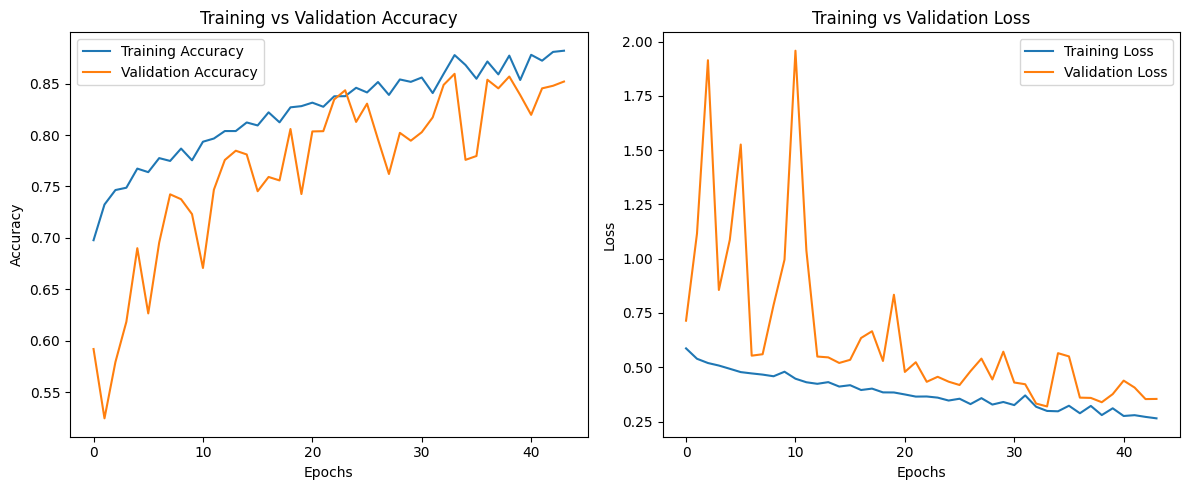

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Function to plot training vs validation accuracy and loss
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss from the history dictionary.

    Args:
        history (dict): Dictionary containing training metrics like 'accuracy', 'val_accuracy', 'loss', 'val_loss'.
    """
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Load the saved training history
try:
    with open('mobilenet_training_history.pkl', 'rb') as file:
        history = pickle.load(file)

    # Plot the metrics
    plot_training_history(history)
except FileNotFoundError:
    print("Error: The file 'mobilenet_training_history.pkl' was not found. Please ensure it exists in the current directory.")
except EOFError:
    print("Error: The file 'mobilenet_training_history.pkl' is corrupted or empty.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Evaluating model performance...

Calculating overall metrics...
Overall Accuracy: 0.8421
Generating predictions...

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84      4000
         1.0       0.84      0.84      0.84      4000

    accuracy                           0.84      8000
   macro avg       0.84      0.84      0.84      8000
weighted avg       0.84      0.84      0.84      8000


Macro Average (Percentages): Precision = 84.21%, Recall = 84.21%, F1-Score = 84.21%
Weighted Average (Percentages): Precision = 84.21%, Recall = 84.21%, F1-Score = 84.21%


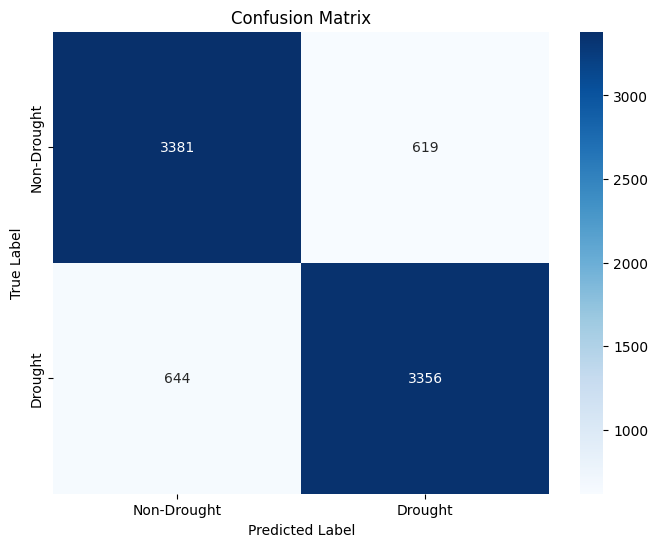

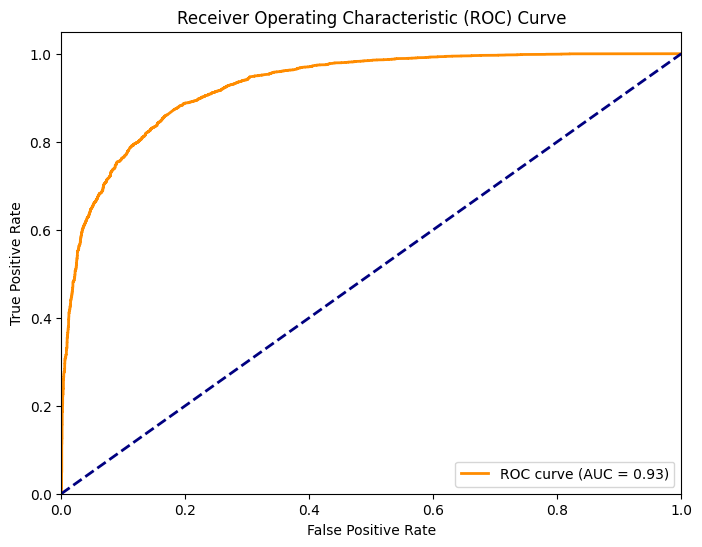


Final Model Performance Metrics:
Accuracy: 0.8421
ROC AUC: 0.9268


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model_performance(model, dataset, steps):
    """
    Evaluate model performance using various metrics and visualizations

    Args:
        model: trained tensorflow model
        dataset: tf.data.Dataset object (preprocessed and batched)
        steps: number of validation steps (validation_samples // batch_size)
    """
    # Use model.evaluate to get the overall accuracy
    print("\nCalculating overall metrics...")
    overall_results = model.evaluate(dataset, steps=steps, verbose=0)
    print(f"Overall Accuracy: {overall_results[1]:.4f}")

    # Get predictions and true labels
    y_pred_proba = []
    y_true = []

    print("Generating predictions...")
    for batch in dataset.take(steps):
        images, labels = batch
        batch_predictions = model.predict(images, verbose=0)
        y_pred_proba.extend(batch_predictions)
        y_true.extend(labels.numpy())

    # Convert to numpy arrays
    y_pred_proba = np.array(y_pred_proba)
    y_true = np.array(y_true)

    # Convert probabilities to binary predictions using 0.5 threshold
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(y_true, y_pred)
    class_report_dict = classification_report(y_true, y_pred, output_dict=True)
    class_report = classification_report(y_true, y_pred)

    # Extract macro and weighted averages
    macro_avg = class_report_dict['macro avg']
    weighted_avg = class_report_dict['weighted avg']

    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # Print detailed metrics
    print("\nClassification Report:")
    print(class_report)
    print(f"\nMacro Average (Percentages): Precision = {macro_avg['precision'] * 100:.2f}%, Recall = {macro_avg['recall'] * 100:.2f}%, F1-Score = {macro_avg['f1-score'] * 100:.2f}%")
    print(f"Weighted Average (Percentages): Precision = {weighted_avg['precision'] * 100:.2f}%, Recall = {weighted_avg['recall'] * 100:.2f}%, F1-Score = {weighted_avg['f1-score'] * 100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Drought', 'Drought'],
                yticklabels=['Non-Drought', 'Drought'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return {
        'accuracy': overall_results[1],
        'confusion_matrix': conf_matrix,
        'classification_report': class_report,
        'roc_auc': roc_auc,
        'fpr': fpr,
        'tpr': tpr
    }


# Define the model path
model_path = "/content/best_mobilenetv2_model.keras"

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Assuming `final_val_dataset` is already defined and batched
BATCH_SIZE = 32
VAL_SAMPLES = 8000  # Your validation set size
validation_steps = VAL_SAMPLES // BATCH_SIZE

# Evaluate the model
print("Evaluating model performance...")
metrics = evaluate_model_performance(model, final_val_dataset, validation_steps)

# Print final metrics
print(f"\nFinal Model Performance Metrics:")
print(f"Accuracy: {metrics['accuracy']:.4f}")
print(f"ROC AUC: {metrics['roc_auc']:.4f}")
